# Deconvoling Gaia errors with Normalizing Flow


In [18]:
import matplotlib.pyplot as plt 

from deconvolution.trainer.trainer import Trainer
from deconvolution.configs.gaia_configs import Deconvolve_Gaia_MAF_RQS_NormFlow as Configs

configs = Configs(DATA = 'h277',
                  FEATURES = ['x', 'y', 'z', 'vx', 'vy', 'vz'],
                  DATA_SPLIT_FRACS = [0.8, 0.2, 0.0],
                  PREPROCESS=['unit_ball_transform', 'standardize'],
                  BATCH_SIZE = 2048,
                  EPOCHS = 100,
                  LR = 1e-4,
                  NUM_BLOCKS = 2,
                  NUM_RQS_BINS = 20,
                  TAIL_BOUND = 10, 
                  DIM_HIDDEN = 128,
                  NUM_TRANSFORMS = 5,
                  NUM_WORKERS = 8,
                  PIN_MEMORY = True,
                  DEVICE = 'cpu'
                  )
#...set working directory for results:

configs.set_workdir(path='../../results', save_config=True)


Preparing experiment: error deconvolution for Gaia phase-space data at workdir:
#======================================================================================
INFO: created directory: ../../results/h277.DeconvolutionFlow.MAF_RQS.2024.02.29_13h14
#======================================================================================
+---------------------+--------------------------------------------------------------------------------------------------------+
| Parameters          | Values                                                                                                 |
+---------------------+--------------------------------------------------------------------------------------------------------+
| DATA                | h277                                                                                                   |
| DATASET             | ['../../data/gaia/data.angle_340.smeared_00.npy', '../../data/gaia/data.angle_340.smeared_00.cov.npy'] |
| FEATURES  

In [19]:
from deconvolution.datamodules.gaia.datasets import GaiaDataset
gaia = GaiaDataset(configs)

INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 128667, validation size: 32166, testing sizes: 1


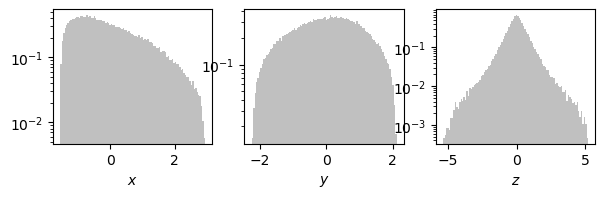

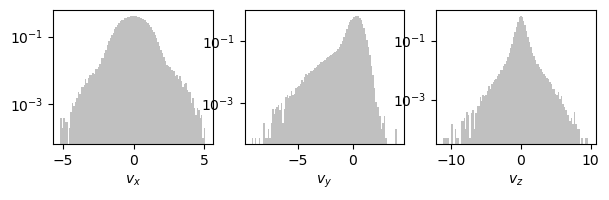

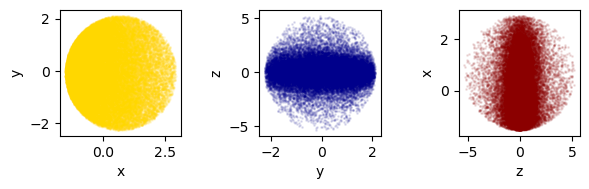

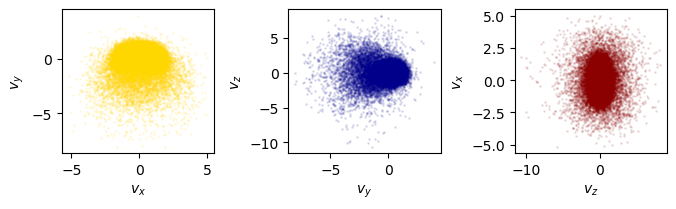

In [20]:
from deconvolution.datamodules.gaia.dataloader import GaiaDataLoader 
dataloader = GaiaDataLoader (gaia, configs)

#...phase space plots
from utils import results_plots

results_plots(gaia.target_preprocess[..., :3],  
              features=[r'$x$', r'$y$', r'$z$'], 
              num_particles=100000,
              figsize=(7, 2.2),
              name_file='gaia_postions')

results_plots(gaia.target_preprocess[..., 3:6],  
              features=[r'$v_x$', r'$v_y$', r'$v_z$'], 
              num_particles=100000,
              figsize=(7, 2.2),
              name_file='gaia_postions')

coord = ['x', 'y', 'z']
color=['gold', 'darkblue', 'darkred']
fig, ax = plt.subplots(1, 3, figsize=(6, 2))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].scatter(gaia.target_preprocess[:50000, i], gaia.target_preprocess[:50000, j], s=1, alpha=0.1, c=color[i])
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()

coord = [r'$v_x$', r'$v_y$', r'$v_z$']
color=['gold', 'darkblue', 'darkred']
fig, ax = plt.subplots(1, 3, figsize=(7, 2.2))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].scatter(gaia.target_preprocess[:50000, i+3], gaia.target_preprocess[:50000, j+3], s=1, alpha=0.1, c=color[i])
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()

In [21]:
from deconvolution.datamodules.gaia.datasets import GaiaDataset 
from deconvolution.datamodules.gaia.dataloader import GaiaDataLoader 
from deconvolution.models.nflow_nets import MAFPiecewiseRQS
from deconvolution.dynamics.nf.normflows import NormalizingFlow


flow = Trainer(dynamics=NormalizingFlow(configs),
               model=MAFPiecewiseRQS(configs), 
               dataloader=GaiaDataLoader(gaia, configs), 
               configs=configs)
flow.train()

number of training parameters: 477516
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 128667, validation size: 32166, testing sizes: 1


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
from deconvolution.pipelines.SamplingPipeline import NormFlowPipeline 
from deconvolution.datamodules.gaia.dataprocess import PostProcessGaiaData 

pipeline = NormFlowPipeline(trained_model=flow, 
                            best_epoch_model=True, 
                            postprocessor=PostProcessGaiaData)

pipeline.generate_samples(num=50000)

/Users/dario/Dropbox/PROJECTS/ML/Deconvolution/experiments/Gaia/utils.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


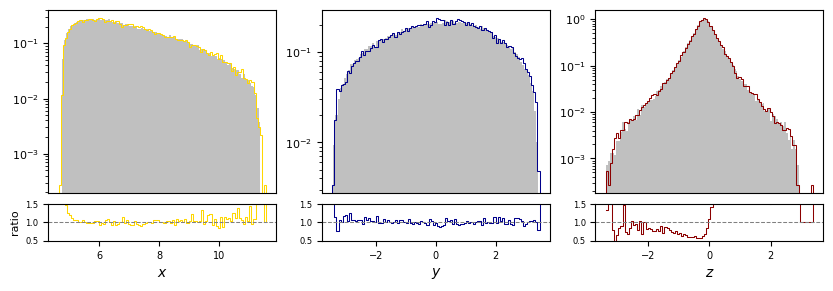

/Users/dario/Dropbox/PROJECTS/ML/Deconvolution/experiments/Gaia/utils.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


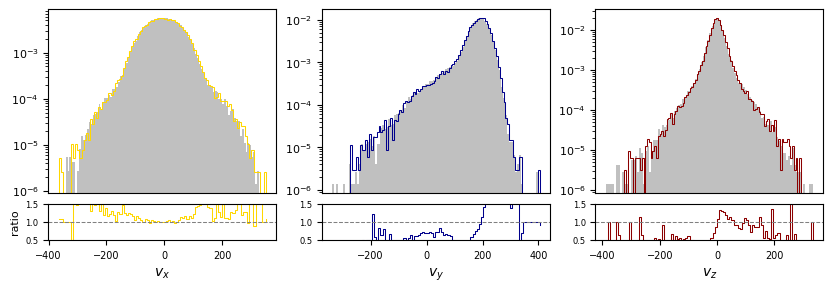

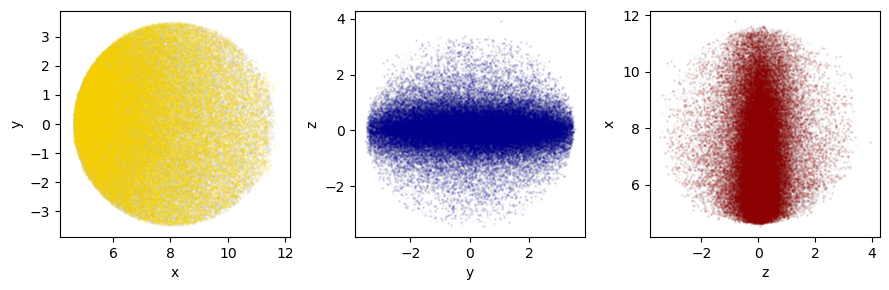

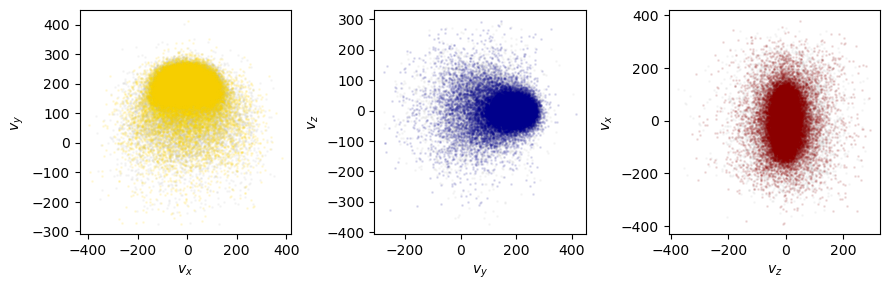

In [23]:
from utils import results_plots

results_plots(gaia.target[..., :3],  
              generated=pipeline.target[..., :3],
              save_dir=configs.WORKDIR,
              features=[r'$x$', r'$y$', r'$z$'], 
              num_particles=100000,
              name_file='gaia_postions')

results_plots(gaia.target[..., 3:], 
              generated=pipeline.target[..., 3:],
              save_dir=configs.WORKDIR,
              features=[r'$v_x$', r'$v_y$', r'$v_z$'], 
              num_particles=100000,
              name_file='gaia_velociites')

coord = ['x', 'y', 'z']
color=['gold', 'darkblue', 'darkred']
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].scatter(gaia.target[:50000, i], gaia.target[:50000, j], s=1, alpha=0.1, c='silver')
    ax[i].scatter(pipeline.target[:50000, i], pipeline.target[:50000, j], s=1, alpha=0.1, c=color[i])
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()

coord = [r'$v_x$', r'$v_y$', r'$v_z$']
color=['gold', 'darkblue', 'darkred']
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].scatter(gaia.target[:50000, i+3], gaia.target[:50000, j+3], s=1, alpha=0.1, c='silver')
    ax[i].scatter(pipeline.target[:50000, i+3], pipeline.target[:50000, j+3], s=1, alpha=0.1, c=color[i])
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()


/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_62019/1598070547.py:26: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(8)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_62019/1598070547.py:35: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax_ratio.set_ylim(0.5, 1.5, 0) # Adjust this as needed
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_62019/1598070547.py:39: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(7)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_62019/1598070547.py:41: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be remo

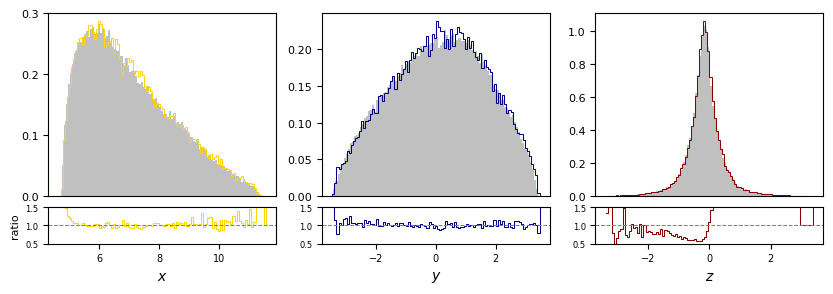

/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_62019/1598070547.py:26: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(8)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_62019/1598070547.py:35: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax_ratio.set_ylim(0.5, 1.5, 0) # Adjust this as needed
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_62019/1598070547.py:39: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(7)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_62019/1598070547.py:41: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be remo

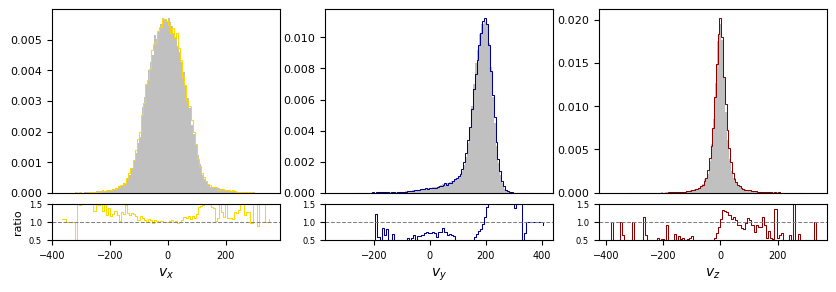

In [25]:
results_plots(gaia.target[..., :3],  
              generated=pipeline.target[..., :3],
              save_dir=configs.WORKDIR,
              features=[r'$x$', r'$y$', r'$z$'], 
              num_particles=100000,
              log=False,
              name_file='gaia_postions')

results_plots(gaia.target[..., 3:], 
              generated=pipeline.target[..., 3:],
              save_dir=configs.WORKDIR,
              log=False,
              features=[r'$v_x$', r'$v_y$', r'$v_z$'], 
              num_particles=100000,
              name_file='gaia_velociites')

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def results_plots(gaia_data, 
                  generated=None, 
                  save_dir=None, 
                  figsize=(10, 3),
                  features=[r'$x$', r'y$', r'$z$'], 
                  num_particles=100000,
                  log = True,
                  name_file='gaia'):
    
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 3, height_ratios=[5, 1])
    gs.update(hspace=0.1) 
    
    for idx, feature in enumerate(features):
        ax = fig.add_subplot(gs[idx])
        h1, bins, _ = ax.hist(gaia_data[..., idx].flatten()[:num_particles], bins=100,  color='silver', density=True, log=log)
        if generated is not None:
            h2, _, _ = ax.hist(generated[..., idx].flatten()[:num_particles], bins=100, color=['gold', 'darkblue', 'darkred'][idx], histtype='step', density=True, log=log, lw=0.75)
            ax.set_xticklabels([])
            ax.set_xticks([])
            for tick in ax.yaxis.get_major_ticks():
               tick.label.set_fontsize(8)
        else:
            ax.set_xlabel(feature)
        
        # Ratio plot
        if generated is not None:
            ax_ratio = fig.add_subplot(gs[idx + 3])
            ratio = np.divide(h1, h2, out=np.ones_like(h2), where=h2 != 0)
            ax_ratio.plot(0.5 * (bins[:-1] + bins[1:]), ratio, color=['gold', 'darkblue', 'darkred'][idx], lw=0.75, drawstyle='steps-post')
            ax_ratio.set_ylim(0.5, 1.5, 0) # Adjust this as needed
            ax_ratio.set_xlabel(feature)
            ax_ratio.axhline(1, color='gray', linestyle='--', lw=0.75)
            for tick in ax_ratio.xaxis.get_major_ticks():
               tick.label.set_fontsize(7)
            for tick in ax_ratio.yaxis.get_major_ticks():
              tick.label.set_fontsize(6)  
            if idx == 0:
                ax_ratio.set_ylabel('ratio', fontsize=8)
            ax_ratio.set_yticks([0.5, 1, 1.5])
    if save_dir is not None:
        plt.savefig(save_dir + '/'+name_file+'.pdf')
    plt.tight_layout()
    plt.show()




In [ ]:
gaussian